# Wisconsin Breast Cancer Diagnosis Prediction

<img src="https://miro.medium.com/v2/resize:fit:622/format:webp/1*YsCWIhAVQRA3bzJr8mtpCA.png">

## Introduction

In this project, we will predict whether a detected cancer is benign or malignant for anonymous patients. Breast Cancer Wisconsin (Diagnostic) Data Set Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. The 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

## Data Loading

First, we import the necessary libraries. The main ones include:
 - Numpy: numerical operations
 - Pandas: data operations (how we store/manipulate our main dataframe)
 - Seaborn and Matplotlib: data visualization
 - sklearn (Scikit-Learn): machine learning library

In [25]:
import os
import numpy as np 
import pandas as pd 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows",None)
from sklearn import preprocessing
import matplotlib 
matplotlib.style.use('ggplot')
from sklearn.preprocessing import LabelEncoder

Now, we import the dataset and look at the first few rows to get an idea of what our data looks like.

In [2]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


We can call the "dtypes" property to get a list of all of the columns and their data types.

In [3]:
df.dtypes.head()

id                  int64
diagnosis          object
radius_mean       float64
texture_mean      float64
perimeter_mean    float64
dtype: object

## Data Cleansing

We need to convert all the Object type columns to String types to work on them.

In [4]:
string_col = df.select_dtypes(include="object").columns
df[string_col]=df[string_col].astype("string")

In [5]:
df.isnull().any()

id                         False
diagnosis                  False
radius_mean                False
texture_mean               False
perimeter_mean             False
area_mean                  False
smoothness_mean            False
compactness_mean           False
concavity_mean             False
concave points_mean        False
symmetry_mean              False
fractal_dimension_mean     False
radius_se                  False
texture_se                 False
perimeter_se               False
area_se                    False
smoothness_se              False
compactness_se             False
concavity_se               False
concave points_se          False
symmetry_se                False
fractal_dimension_se       False
radius_worst               False
texture_worst              False
perimeter_worst            False
area_worst                 False
smoothness_worst           False
compactness_worst          False
concavity_worst            False
concave points_worst       False
symmetry_w

We see that the only column with any NA values is the last column, in which every value is actually NA, so we remove it from the dataset.

In [7]:
na_cols = df.columns[df.isnull().any().tolist()].tolist()
ref_df = df.drop(na_cols, axis=1)

We subset only the numerical columns to create the features dataframe.

Also, we subset only the string columns to create the labels dataframe.

In [8]:
num_col = ref_df.select_dtypes(include="float64").columns.tolist()
feat_df = ref_df[num_col]

str_col = ref_df.select_dtypes(include="string").columns.tolist()
label_df = ref_df[str_col]

In our remaining dataset, we have no blank values. However, if there were some NA values that we wanted to fill in, we could use sklearn's impute function as seen below, which fills in the missing values based on the mean:

```python
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(df[['column_with_na']])
df['column_with_na'] = imputer.transform(df[['column_with_na']])

```


## Exploratory Data Analysis

### Heatmap

Now, we create a heatmap for the features to see which ones are correlated.

<Axes: >

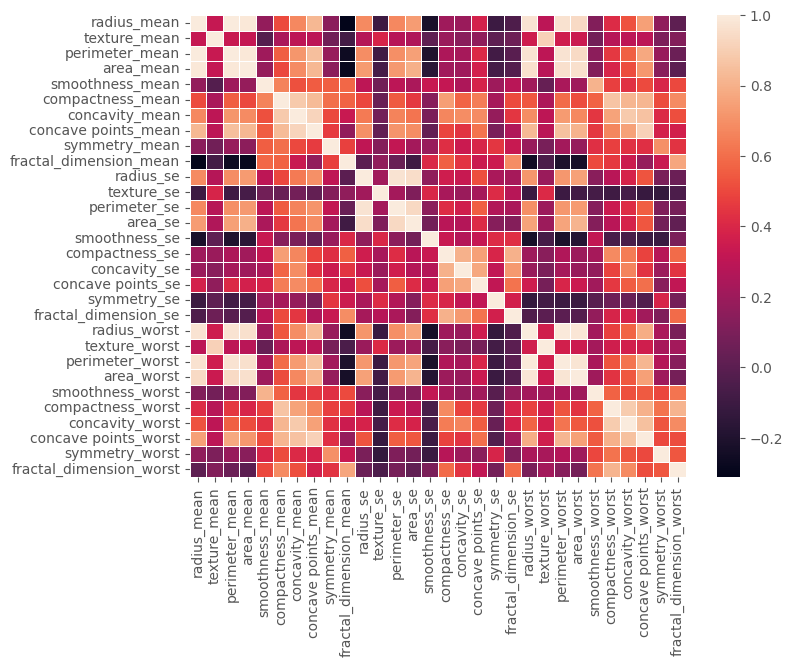

In [9]:
plt.figure(figsize=(8, 6))
corr = feat_df.corr()
sns.heatmap(corr, linewidths=0.5) #, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)

In the heatmap above, the lighter the color, the more correlated the two features are.
Obviously, a feature compared with itself (the light diagonal line across the middle) will be white because it has a one-to-one correlation.

We see that the radius, perimeter, and area features for both mean and worst are highly correlated, but not correlated with the texture.

The fractal dimension, symmetry, smoothness, and texture seem to have slightly negative correlations with some of the other features (black squares).

### Histogram

First, we look at the frequency histogram of the radius mean for the different labels (if the tumors are malignant (red) or benign (green)).

Text(0.5, 1.0, 'Radius Mean Frequency')

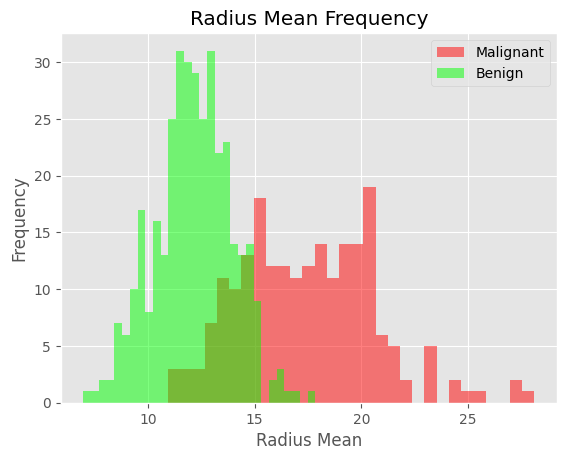

In [10]:
m = plt.hist(ref_df[ref_df["diagnosis"] == "M"].radius_mean,bins=30,fc = (1,0,0,0.5),label = "Malignant")
b = plt.hist(ref_df[ref_df["diagnosis"] == "B"].radius_mean,bins=30,fc = (0,1,0,0.5),label = "Benign")
plt.legend()
plt.xlabel('Radius Mean')
plt.ylabel('Frequency')
plt.title('Radius Mean Frequency')

We see that the radius mean for this dataset is higher for malignant tumors than benign tumors. Further, the frequency distribution for benign tumors looks approximately normal (Gaussian).

We also see that there are some outliers in the frequency distribution. Next, we can look at a boxplot to see how our outliers are distributed.

### Boxplot / Summary Statistics

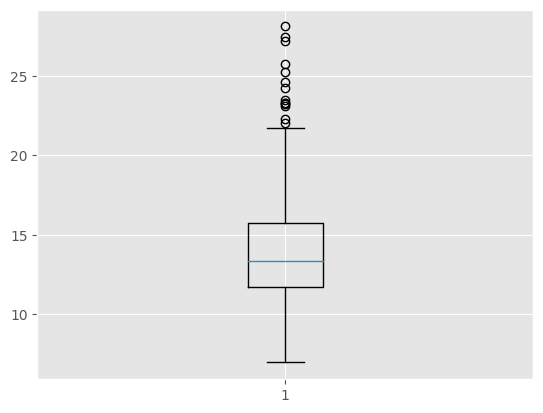

In [29]:
plt.boxplot(ref_df['radius_mean'])
plt.show()

Matplotlib uses the standard $1.5*IQR$ for the outliers:
 - Below $Q_1$-$1.5*$($Q_3$-$Q_1$)
 - Above $Q_3$+$1.5*$($Q_3$-$Q_1$)

where $Q_1$ and $Q_3$ are the 25th and 75th percentiles, respectively. So, we have quite a few outliers above our range.

We can print some summary statistics for benign and malignant tumors:

In [41]:
df_benign = ref_df[ref_df['diagnosis']=='B']
df_malig = ref_df[ref_df['diagnosis']=='M']

In [62]:
print('Benign Tumor Radius Mean Statistics:\n', df_benign.radius_mean.describe())

Benign Tumor Radius Mean Statistics:
 count    357.000000
mean      12.146524
std        1.780512
min        6.981000
25%       11.080000
50%       12.200000
75%       13.370000
max       17.850000
Name: radius_mean, dtype: float64


In [61]:
print('Malignant Tumor Radius Mean Statistics:\n', df_malig.radius_mean.describe())

Malignant Tumor Radius Mean Statistics:
 count    212.000000
mean      17.462830
std        3.203971
min       10.950000
25%       15.075000
50%       17.325000
75%       19.590000
max       28.110000
Name: radius_mean, dtype: float64


We have many more benign tumors in our dataset. Clearly, there is a significant difference between the radius mean of benign tumors and malignant tumors.

### Kernel Density Estimate (KDE) Plots

Kernel density estimation is used to estimate probability density functions (PDFs). We can create an estimated and smoothed joint PDF for two or more features using this method.

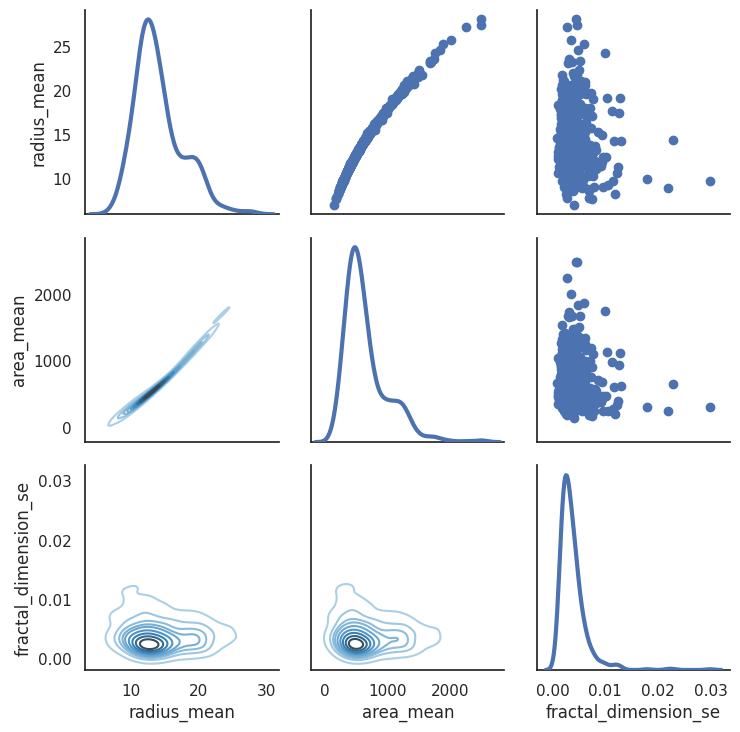

In [67]:
# We can look at the relationship between two or more features (joint distributions)
sns.set(style = "white")
plot_df = ref_df.loc[:,["radius_mean","area_mean","fractal_dimension_se"]]
g = sns.PairGrid(plot_df,diag_sharey = False,)
g.map_lower(sns.kdeplot,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,lw =3)
plt.show()

## Artificial Neural Network (ANN)

#### We build our ANN using Pytorch. First, we import what is necessary to build our ANN. Then, we define our features/labels and our training/test datasets.

In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [93]:
#create our features (X) and label (y) matrix/vector
X = ref_df.iloc[:, 2:].values
y = ref_df.iloc[:, 1].values

# Encoding categorical data into binary 
# 0 for Benign ('B') and 1 for Malignant ('M')
from sklearn.preprocessing import LabelEncoder
labelencoder_X = LabelEncoder()
y = labelencoder_X.fit_transform(y)

#Feature Scaling (scaling the data)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)  # Binary labels (0 or 1)

# Split the data into training and testing sets
# test set is 10% of total data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=1)

#### Now, we define the ANN by inheriting from the nn.Module class (used to build custom machine learning models):

In [94]:
class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(30, 16)  # Input layer to hidden layer (30 input features)
        self.dropout1 = nn.Dropout(0.1) # dropout layer to prevent overclassification
        self.fc2 = nn.Linear(16, 16)  # Hidden layer 1 to hidden layer 2
        self.dropout2 = nn.Dropout(0.1) # dropout layer to prevent overclassification
        self.fc3 = nn.Linear(16, 1)  # Hidden layer 2 to output layer
        self.sigmoid = nn.Sigmoid()   # Sigmoid activation for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layers
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))  # Output layer with sigmoid for binary classification
        return x

#### Finally, we specify the loss function and optimizer, then define how to run each epoch to train the data. We print out the loss at each epoch and print out the final accuracy after predicting on the test set using our trained model.

In [120]:

# Initialize the model, loss function, and optimizer
model = SimpleANN()

# Binary Cross Entropy Loss and Optimizer (Adam)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# These are manually set using trial and error
# Future improvement opportunity would be to optimize these settings automatically
batch_size = 100
num_epochs = 150

# Create DataLoader for training and testing data
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

#create the train and test loaders using batches of the train/test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the model
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode (enables dropout)
    running_loss = 0.0

    #run for each batch
    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        outputs = outputs.squeeze()  # Flatten output to match target shape

        # Compute the loss
        loss = criterion(outputs, labels.float())  # Use float for binary labels

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

    avg_loss = running_loss / len(train_loader)
    if (epoch+1) % 10 == 0:  # Print every 10 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Evaluate the model
model.eval()  # Set the model to evaluation mode (disables dropout)
with torch.no_grad():
    outputs = model(X_test)
    predicted = (outputs.squeeze() > 0.5).float()  # Apply threshold of 0.5 to get binary predictions
    accuracy = (predicted == y_test).float().mean()  # Calculate accuracy
    print(f'Accuracy on test set: {accuracy:.4f}')
    

Epoch [10/150], Loss: 2.5361
Epoch [20/150], Loss: 0.8980
Epoch [30/150], Loss: 0.4474
Epoch [40/150], Loss: 0.3702
Epoch [50/150], Loss: 0.3114
Epoch [60/150], Loss: 0.3290
Epoch [70/150], Loss: 0.2875
Epoch [80/150], Loss: 0.2580
Epoch [90/150], Loss: 0.2645
Epoch [100/150], Loss: 0.3068
Epoch [110/150], Loss: 0.2561
Epoch [120/150], Loss: 0.2539
Epoch [130/150], Loss: 0.2207
Epoch [140/150], Loss: 0.2174
Epoch [150/150], Loss: 0.2736
Accuracy on test set: 0.9825


#### We can view the prediction accuracy using a confusion  matrix, which tells us how many predictions were accurate and how many predictions were false-positives or false-negatives. 

#### We see below that the only incorrect prediction (in this run) was a false-positive, where a tumor was labeled malignant when it was actually benign. In a real-world diagnosis, this errs on the side of caution since further assessment could be done on this mislabeled tumor to designate it as benign with a medical assessment.

[Text(0.5, 1.0, 'Test Set Confusion Matrix'),
 Text(0.5, 19.049999999999997, 'Actual Label'),
 Text(46.25, 0.5, 'Predicted Label')]

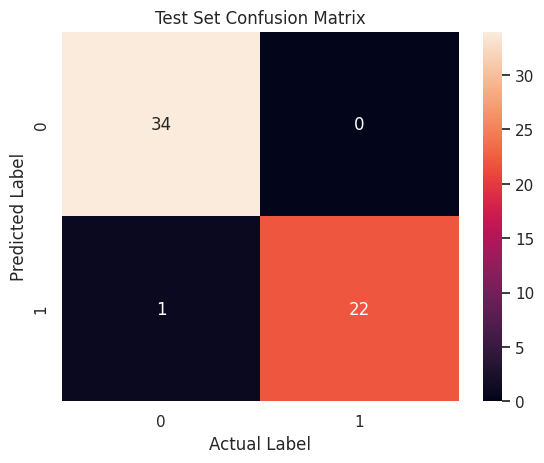

In [122]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predicted)
s = sns.heatmap(cm,annot=True)
s.set(title = 'Test Set Confusion Matrix', xlabel='Actual Label', ylabel = 'Predicted Label')

#### The ANN is quite accurate, prediciting the correct label 98% of the time on the test dataset (in this run)
    - Note: the shuffle in the train dataloader results in a different trained model each time you run the cells so different prediction and accuracy outputs

We could further improve this model if we had more data, or varying the test dataset size to check the accuracy on a larger portion of test data.